In [3]:
# author: Yifan Gu
# referenced material: https://github.com/maziarraissi/PINNs/tree/master/main
# referenced material: https://github.com/nanditadoloi/PINN

In [4]:
import os
import numpy as np
import matplotlib.pyplot as plt
import torch
import random

In [5]:
# parameters
rho = 0.5
dpdx = -2.0
g = 0.4
mu = 0.6
nu = mu/rho
h = 1.0
# sample N points at time zero in terms of (t,y) pairs
N = 30
tz = np.zeros((N,2))
for i in range(N):
  tz[i,0] = 0
  tz[i,1] = random.uniform(0.0,h)
# sample N points on the lower boundary
T = 5.0 # max solution time, can change
lb = np.zeros((N,2))
for i in range(N):
  lb[i,0] = random.uniform(0.0,T)
  lb[i,1] = 0
# sample N points on the upper boundary
ub = np.zeros((N,2))
for i in range(N):
  ub[i,0] = random.uniform(0.0,T)
  ub[i,1] = h
# sample points on f(t,y)
f_samples_indep = []
M = 100
for i in range(M):
  t = np.random.uniform(0.0, T)
  y = np.random.uniform(0.0, h)
  f_samples_indep.append((t,y))
f_samples_indep = np.array(f_samples_indep)
t_samples = torch.from_numpy(f_samples_indep[:,0]).float()
y_samples = torch.from_numpy(f_samples_indep[:,1]).float()
# you want all f values ideally to be zero
f_samples_dep = np.zeros(len(f_samples_indep))
u_samples_indep = np.concatenate((tz,lb,ub))
Vt0 = 0 # time zero; change as needed
Vlb = 0 # lower boundary; change as needed
Vub = 0 # upper boundary; change as needed
u_samples_dep = np.zeros(len(u_samples_indep))
# you want the u values to agree with their IC/BC values
for i in range(len(u_samples_dep)):
  if i < len(tz):
    u_samples_dep[i] = Vt0 
  elif i < len(tz) + len(lb):
    u_samples_dep[i] = Vlb
  else:
    u_samples_dep[i] = Vub
# pack np arrays into tensors
u_indep_tensor = torch.from_numpy(u_samples_indep).float()
u_dep_tensor = torch.from_numpy(u_samples_dep).float()
f_indep_tensor = torch.from_numpy(f_samples_indep).float()
f_dep_tensor = torch.from_numpy(f_samples_dep).float()

In [6]:
class PINN(torch.nn.Module): 
  def __init__(self):
    super(PINN,self).__init__()
    self.m1 = torch.nn.Linear(2,100)
    self.m2 = torch.nn.Linear(100,100)
    self.m3 = torch.nn.Linear(100,1)
    # change the number of layers or neurons if needed
  def forward(self,u):
    layer_1 = torch.tanh(self.m1(u))
    layer_2 = torch.tanh(self.m2(layer_1))
    layer_3 = torch.tanh(self.m3(layer_2))
    # change the activation function if needed
    return layer_3

In [7]:
def f_map(u,t,y): # compute f from u
  u = torch.reshape(u,(-1,))
  u_t = torch.gradient(u,spacing=(t,))[0]
  u_y = torch.gradient(u,spacing=(y,))[0]
  u_yy = torch.gradient(u_y,spacing=(y,))[0]
  return u_t + dpdx/rho - nu*u_yy - g

In [8]:
def train(model,optimizer,criterion,u_indep,u_dep,f_indep,f_dep,epochs):
  for e in range(1,epochs+1):
    optimizer.zero_grad()
    model.train()
    u_output = torch.reshape(model(u_indep),(-1,))
    # MSE wrt u
    u_loss = criterion(u_output,u_dep)
    u = model(f_indep)
    f_output = f_map(u,t_samples,y_samples)
    # MSE wrt f
    f_loss = criterion(f_output,f_dep)
    loss = u_loss + f_loss
    loss.backward()
    optimizer.step()
    print(f"| epoch {e:2d} | loss {loss:.6f}")

In [9]:
net = PINN()
optimizer = torch.optim.Adam(net.parameters(),lr=0.001)
criterion = torch.nn.MSELoss()
train(net,optimizer,criterion,u_indep_tensor,u_dep_tensor,f_indep_tensor,f_dep_tensor,2000)

| epoch  1 | loss 13877210.000000
| epoch  2 | loss 3400693.500000
| epoch  3 | loss 10920424.000000
| epoch  4 | loss 5170133.500000
| epoch  5 | loss 172728.078125
| epoch  6 | loss 1788475.375000
| epoch  7 | loss 4790977.500000
| epoch  8 | loss 3911307.000000
| epoch  9 | loss 1223890.000000
| epoch 10 | loss 4534.185547
| epoch 11 | loss 627298.812500
| epoch 12 | loss 1682280.750000
| epoch 13 | loss 2067780.625000
| epoch 14 | loss 1645052.750000
| epoch 15 | loss 862559.562500
| epoch 16 | loss 225866.390625
| epoch 17 | loss 870.593018
| epoch 18 | loss 159587.312500
| epoch 19 | loss 475511.593750
| epoch 20 | loss 694047.437500
| epoch 21 | loss 688946.375000
| epoch 22 | loss 502779.187500
| epoch 23 | loss 264807.031250
| epoch 24 | loss 85112.195312
| epoch 25 | loss 6483.777344
| epoch 26 | loss 15121.527344
| epoch 27 | loss 71955.625000
| epoch 28 | loss 137649.656250
| epoch 29 | loss 184966.546875
| epoch 30 | loss 201617.703125
| epoch 31 | loss 187946.015625
| epo

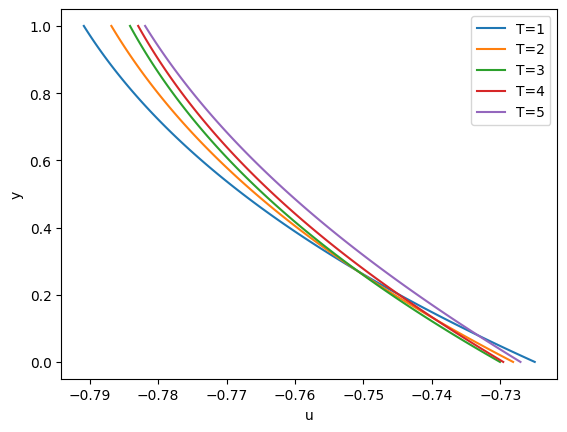

In [10]:
# plot the solution
N = 100
T = [i for i in range(1,6)]
dy = h/N
ty = np.zeros((N+1,2))
for t in T:
  for i in range(N+1):
    ty[i,0] = t
    ty[i,1] = i*dy
  ty_tensor = torch.from_numpy(ty).float()
  u_tensor = net.forward(ty_tensor)
  u_tensor = torch.reshape(u_tensor,(-1,))
  u = u_tensor.detach().numpy()
  y = ty[:,1]
  plt.plot(u,y,label='T={}'.format(t))
  plt.xlabel('u')
  plt.ylabel('y')
  plt.legend()
plt.show()